<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

## Exercise 2: Inhibitory connectivity 
    
In the data walkthrough, we visualized the connectivity of excitatory neurons with each other. Here, we will extend this analysis to include inhibitory neurons. 

    
</div>

In [1]:
mat_version = 1300

# Paths to compiled data for this workshop
syn_data_url = f"https://github.com/sdorkenw/MICrONS_workshop_CNC_forum/raw/refs/heads/main/data/synapses_proofread_V1_neurons_{mat_version}.feather"
cell_data_url = f"https://github.com/sdorkenw/MICrONS_workshop_CNC_forum/raw/refs/heads/main/data/cell_info_{mat_version}.feather" 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 2.1
Reference the data walkthrough, and copy over the local functions  `filter_synapse_table` and `sort_matrix_by_types`, as they will be critical for this exercise.
    
</div>

In [3]:
def filter_synapse_table(synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None):   
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """
    
    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        pre_m = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_m = np.ones(len(synapse_table), dtype=bool)
        
    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        post_m = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_m = np.ones(len(synapse_table), dtype=bool)
        
    return synapse_table[pre_m & post_m]

def sort_matrix_by_types(mat: pd.DataFrame, 
                         labels: pd.DataFrame, 
                         label_type_col: str = "cell_type_auto", 
                         label_id_col: str = "pt_root_id", 
                         post_labels: pd.DataFrame = None, 
                         post_label_type_col: str = None, 
                         post_label_id_col: str = None):
    """Sorts (synapse) matrix by labels.

    This function assumes a square synapse matrix!

    Args:
        mat: synapse matrix as pandas DataFrame
        labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        label_type_col: column name in labels for cell types
        label_id_col: column name in labels for root ids
        post_labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        post_label_type_col: column name in labels for cell types
        post_label_id_col: column name in labels for root ids

    Returns:
        mat_sorted: sorted matrix
        mat_labels: sorted labels; has the same length as matrix
    """
    
    if post_labels is None:
        post_labels = labels
    if post_label_type_col is None:
        post_label_type_col = label_type_col
    if post_label_id_col is None:
        post_label_id_col = label_id_col
        
    mat_sorted = mat.copy()
    
    pre_mat_labels = np.array(labels.set_index(label_id_col).loc[mat_sorted.index][label_type_col])
    pre_sorting = np.argsort(pre_mat_labels)

    post_mat_labels = np.array(post_labels.set_index(post_label_id_col).loc[mat_sorted.T.index][post_label_type_col])
    post_sorting = np.argsort(post_mat_labels)

    mat_sorted = mat_sorted.iloc[pre_sorting].T.iloc[post_sorting].T

    return mat_sorted, pre_mat_labels[pre_sorting], post_mat_labels[post_sorting]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 2.2
Load the <b>cell_df</b> and the <b>syn_df</b> dataframes. Using `filter_synapse_table`, filter the synapse table to only contain proofread <b>Inhibitory and Excitatory</b> cells for which we have cell type information.

Plot the square matrix of connectivity, sorted by cell type with `sort_matrix_by_type`. Do you see a difference in connectivity structure among the cell types?

Tip: This is the equivalent of what you did for only the <b>Excitatory</b> cells in the walkthrough.
    
</div>

In [4]:
# Load cell_df
cell_df = pd.read_feather(cell_data_url)

# Load syn_df
syn_df = pd.read_feather(syn_data_url)

# Get the proofread root ids of the inhibitory cells
proof_root_ids = np.array(cell_df[cell_df["proofreading_strategy"] != ""]["pt_root_id"])


In [5]:
# Filter the synapse table to include proofread and cell-types cells
proof_proof_syn_table = filter_synapse_table(syn_df, pre_root_ids=proof_root_ids, post_root_ids=proof_root_ids)

# Pivot synapse table into a matrix
syn_mat = proof_proof_syn_table.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", 
                                            values="size", aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)

syn_mat = syn_mat.reindex(columns=np.array(syn_mat.index))

# Sort matrix by cell type
syn_mat_ct, syn_mat_cell_types, _ = sort_matrix_by_types(syn_mat, cell_df, label_type_col="cell_type_auto")

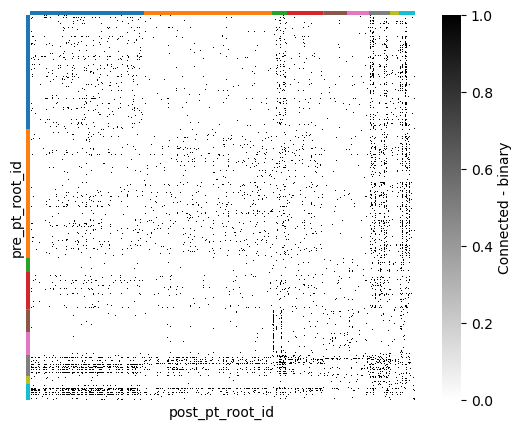

In [6]:
cts, ct_idx = np.unique(syn_mat_cell_types, return_inverse=True)
ct_colors = plt.get_cmap("tab10")(ct_idx)

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(syn_mat_ct, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar_kws={"label": "Connected - binary"})


# Adding row and column colors for cell types
for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.01, i), width=0.01, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False))

for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(i, 1), height=0.01, width=1, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False))  


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### 2.3 Extending the connectivity matrix
The automated cell type predictions allow us to extend the synapse matrix beyond proofread cells. For inhibitory cells, their output connectivity can differ subtantially between cell types. 

Note now that the synapse matrix will be rectangular because we have many more postsynaptic targets than presynaptic neurons.

To do this, change the following from Task 2.2 when using `filter_synapse_table`.
1. select only the proofread <b> inhibitory neurons</b> as your pre_ids
2. change the post_root_ids to any cell in the `cell_df`
3. modify the plot to sort column and rows independently while keeping same colormap
    
</div>

In [7]:
# Get the proofread root ids of the inhibitory cells
proof_I_root_ids = np.array(cell_df[np.array(cell_df["proofreading_strategy"] != "") & np.array(cell_df["coarse_cell_type_auto"] == "I")]["pt_root_id"])

# Filter the synapse table 
proof_syn_table = filter_synapse_table(syn_df, pre_root_ids=proof_I_root_ids, post_root_ids=cell_df.pt_root_id)

# Pivot synapse table into a matrix
syn_mat_rect = proof_syn_table.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", 
                                            values="size", aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)

syn_mat_rect = syn_mat_rect.reindex(columns=np.array(syn_mat.index))

In [8]:
# Sort matrix by cell type
syn_mat_rect_ct, pre_syn_mat_cell_types, post_syn_mat_cell_types = sort_matrix_by_types(syn_mat_rect, cell_df, label_type_col="cell_type_auto")

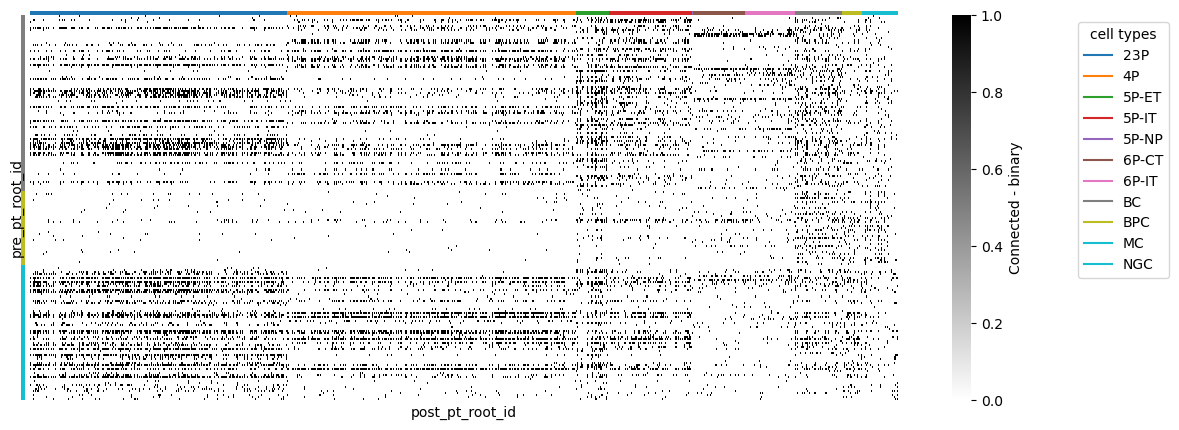

In [9]:
# map labels together in colormap
pre_post_cts, pre_post_ct_idx = np.unique(np.append(pre_syn_mat_cell_types,
                                                    post_syn_mat_cell_types),
                                                    return_inverse=True)
row_col_ct_colors = plt.get_cmap("tab10")(pre_post_ct_idx)

row_ct_colors = row_col_ct_colors[:len(pre_syn_mat_cell_types)]
col_ct_colors = row_col_ct_colors[len(pre_syn_mat_cell_types):]

fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(syn_mat_rect_ct, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=False,
            cbar_kws={"label": "Connected - binary"})

# Adding row and column colors for cell types
for i, color in enumerate(row_ct_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.01, i), width=0.005, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False))

for i, color in enumerate(col_ct_colors):
    ax.add_patch(plt.Rectangle(xy=(i, 1), height=0.01, width=1, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False))    
from matplotlib.lines import Line2D
# add a legend for the cell types
legend_elements = [matplotlib.lines.Line2D([0], [0], color=plt.get_cmap("tab10")(i), label=ct) for i, ct in enumerate(pre_post_cts)]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.2, 1), title="cell types")